# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [84]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [85]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [86]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-09-05 09:00:00+09:00,42983.468750,43220.941406,42983.468750,43098.589844,0,0.0,0.0
2025-09-05 09:15:00+09:00,43117.179688,43185.460938,43043.609375,43156.968750,0,0.0,0.0
2025-09-05 09:30:00+09:00,43158.171875,43189.550781,42963.750000,42963.750000,0,0.0,0.0
2025-09-05 09:45:00+09:00,42965.351562,43020.398438,42916.871094,42944.890625,0,0.0,0.0
2025-09-05 10:00:00+09:00,42942.109375,42943.941406,42870.449219,42895.179688,0,0.0,0.0
2025-09-05 10:15:00+09:00,42894.671875,42952.308594,42892.210938,42920.398438,0,0.0,0.0
2025-09-05 10:30:00+09:00,42914.988281,42973.210938,42901.839844,42965.269531,0,0.0,0.0
2025-09-05 10:45:00+09:00,42962.628906,42973.289062,42932.371094,42955.089844,0,0.0,0.0
2025-09-05 11:00:00+09:00,42953.808594,42953.808594,42855.308594,42861.878906,0,0.0,0.0


## 前日終値の取得

In [87]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-08-29 00:00:00+09:00    42718.468750
2025-09-01 00:00:00+09:00    42188.789062
2025-09-02 00:00:00+09:00    42310.488281
2025-09-03 00:00:00+09:00    41938.890625
2025-09-04 00:00:00+09:00    42580.269531
2025-09-05 00:00:00+09:00    42932.160156
Name: Close, dtype: float64


Date
2025-09-04 00:00:00+09:00    42580.269531
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [88]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+403.20


## ローソク足チャート（小さいサイズ）

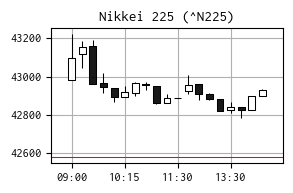

In [89]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()